In [1]:
import numpy as np
import astropy as ap
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math as m
import argparse
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.modeling.models import custom_model
from matplotlib.backends.backend_pdf import PdfPages
import scipy as sp
from scipy import integrate
import uncertainties as unc
import uncertainties
from uncertainties import unumpy as unp
import kcorrect
import kcorrect.utils as ut
from astropy.cosmology import FlatLambdaCDM
import pandas as pd
import matplotlib as mp
import os

In [2]:
plt.style.use('seaborn-whitegrid')
plt.style.use('default')
params = {
    'axes.labelsize': 11,
    'legend.fontsize': 12,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'text.usetex': True,
    'figure.figsize': [7, 4], # instead of 4.5, 4.5
    'grid.linestyle': ':',
    'axes.edgecolor' : '0',
    'font.family':'serif',
    'font.serif':'Computer Modern'
    }
mp.rcParams.update(params)

In [3]:
def autolabel(rects,thecolor,lcbgs,gals,ax):
     i=0
     for rect in rects:
          height=rect.get_height()
          print(height)
          if not m.isinf(height):
               axes[ax].text(rect.get_x() + rect.get_width()/2.,
                             height+0.07,
                             '{}'.format(lcbgs[i]) ,
                             ha='center',
                             va='bottom',
                             fontsize='small',
                             color=thecolor)
               axes[ax].text(rect.get_x() + rect.get_width()/2.,
                             height+0.03,
                             '{}'.format(gals[i]) ,
                             ha='center',
                             va='bottom',
                             fontsize='small',
                             color=thecolor)
               i=i+1

def autolabel2(rects,fraction,ax):
    i=0
    for rect in rects:
        height=rect.get_height()
        print(height)
        if not m.isinf(height):
            axes[ax].text(rect.get_x() + rect.get_width()/2.,height+0.01,
                          '{}'.format(fraction[i]) ,
                          ha='center',
                          va='bottom',
                          fontsize='small')
            i=i+1



In [4]:
cosmo=FlatLambdaCDM(H0=70.0,Om0=0.3)
fit=LevMarLSQFitter()
GAL_ALPHA=-1.05
LCBG_ALPHA=-1.0

In [5]:
@uncertainties.wrap
def integratethings(ps,ms,al=None,m=None):
    if al==None:
        al=-1.1
    if m==None:
        m=-18.5
    def integrand(X):
        return (0.4*np.log(10)*ps)*(10**(0.4*(al+1)*(ms-X)))*(np.e**(-np.power(10,0.4*(ms-X))))
    integral,abserr=sp.integrate.quad(integrand,-100,m)
    return integral

In [6]:
CATALOG=pd.read_csv('/home/lrhunt/Astrodata/LCBG_Luminosity_Function/Original_Catalogs/Final_Catalogs/COSMOS_CONVERTED_CATALOG.csv')

In [7]:
Magnitude_Loop_Array=np.stack((np.arange(15,
                                         22.5+0.5,
                                         0.5)[0:len(np.arange(15,
                                                              22.5+0.5,
                                                              0.5))-1],
                               np.arange(15,
                                         22.5+0.5,
                                         0.5)[1:len(np.arange(15,
                                                              22.5+0.5,
                                                              0.5))]),
                              axis=-1)
print('********CALCULATING WEIGHTS********')
tf=open('weights.txt','w')
CATALOG['Spec_Weight']=np.nan
CATALOG['Color_Weight']=np.nan
CATALOG['Surface_Brightness_Weight']=np.nan
for magrange in Magnitude_Loop_Array:
    Num_Good_Spec=len(CATALOG.loc[(CATALOG.subaru_i_mag>magrange[0])&
                              (CATALOG.subaru_i_mag<magrange[1])&
                              (CATALOG.SG_MASTER==0)&
                              ((CATALOG.Z_USE==1)|
                               (CATALOG.Z_USE==2))])
    Num_Bad_Spec=len(CATALOG.loc[(CATALOG.subaru_i_mag>magrange[0])&
                             (CATALOG.subaru_i_mag<magrange[1])&
                             (CATALOG.SG_MASTER==0)&
                             ((CATALOG.Z_USE==3)|
                              (CATALOG.Z_USE==4))])
    Num_Good_Color=len(CATALOG.loc[(CATALOG.subaru_i_mag>magrange[0])&
                               (CATALOG.subaru_i_mag<magrange[1])&
                               (CATALOG.SG_MASTER==0)&
                               ((CATALOG.subaru_B_mag<100)&
                                (CATALOG.subaru_V_mag<100))])
    Num_Bad_Color=len(CATALOG.loc[(CATALOG.subaru_i_mag>magrange[0])&
                              (CATALOG.subaru_i_mag<magrange[1])&
                              (CATALOG.SG_MASTER==0)&
                              ((CATALOG.subaru_B_mag>100)|
                               (CATALOG.subaru_V_mag>100))])
    Num_Bad_Rh=len(CATALOG.loc[(CATALOG.subaru_i_mag>magrange[0])&
                           (CATALOG.subaru_i_mag<magrange[1])&
                           (CATALOG.SG_MASTER==0)&
                           (np.isnan(CATALOG.R_HALF_PIXELS))])
    Num_Good_Rh=len(CATALOG.loc[(CATALOG.subaru_i_mag>magrange[0])&
                            (CATALOG.subaru_i_mag<magrange[1])&
                            (CATALOG.SG_MASTER==0)&
                            (~np.isnan(CATALOG.R_HALF_PIXELS))])
    CATALOG.loc[(CATALOG.subaru_i_mag>magrange[0])&
                (CATALOG.subaru_i_mag<magrange[1])&
                (CATALOG.SG_MASTER==0),
                'Spec_Weight']=float(Num_Good_Spec+Num_Bad_Spec)/float(Num_Good_Spec)
    CATALOG.loc[(CATALOG.subaru_i_mag>magrange[0])&
                (CATALOG.subaru_i_mag<magrange[1])&
                (CATALOG.SG_MASTER==0),
                'Color_Weight']=float(Num_Good_Color+Num_Bad_Color)/float(Num_Good_Color)
    CATALOG.loc[(CATALOG.subaru_i_mag>magrange[0])&
                (CATALOG.subaru_i_mag<magrange[1])&
                (CATALOG.SG_MASTER==0),
                'Surface_Brightness_Weight']=float(Num_Good_Rh+Num_Bad_Rh)/float(Num_Good_Rh)
    print('Spec Weight = {} | Color Weight = {} | Surface Brightness Weight = {}'.format(
        np.round(float(Num_Good_Spec+Num_Bad_Spec)/float(Num_Good_Spec),4),
        np.round(float(Num_Good_Color+Num_Bad_Color)/float(Num_Good_Color),4),
        np.round(float(Num_Good_Rh+Num_Bad_Rh)/float(Num_Good_Rh),4)))

********CALCULATING WEIGHTS********
Spec Weight = 5.75 | Color Weight = 1.0 | Surface Brightness Weight = 2.3
Spec Weight = 5.5 | Color Weight = 1.0 | Surface Brightness Weight = 11.0
Spec Weight = 1.1818 | Color Weight = 1.0 | Surface Brightness Weight = 6.5
Spec Weight = 1.0435 | Color Weight = 1.0 | Surface Brightness Weight = 1.3333
Spec Weight = 1.0566 | Color Weight = 1.0 | Surface Brightness Weight = 2.0
Spec Weight = 1.2267 | Color Weight = 1.011 | Surface Brightness Weight = 1.84
Spec Weight = 1.218 | Color Weight = 1.0 | Surface Brightness Weight = 1.4595
Spec Weight = 1.1867 | Color Weight = 1.0 | Surface Brightness Weight = 1.3021
Spec Weight = 1.1932 | Color Weight = 1.0 | Surface Brightness Weight = 1.4015
Spec Weight = 1.2101 | Color Weight = 1.0 | Surface Brightness Weight = 1.33
Spec Weight = 1.2232 | Color Weight = 1.0 | Surface Brightness Weight = 1.2778
Spec Weight = 1.2264 | Color Weight = 1.0 | Surface Brightness Weight = 1.3045
Spec Weight = 1.2818 | Color Weight

In [24]:
LCBG_DIR='/home/lrhunt/Projects/LCBG_LUMINOSITY_FUNCTION/LCBGLFOUT/apmag225/zucca_z_bins/'
LCBG_LFS={}
LCBG_LFS_INDEX=[]
for file in os.listdir(LCBG_DIR):
    if file.endswith('csv'):
        LCBG_LFS[file.split('.csv')[0]]=pd.read_csv(LCBG_DIR+'/'+file)
        LCBG_LFS_INDEX.append(file.split('.csv')[0])
    if file.endswith('.xlsx'):
        LCBG_FIT_VALS=pd.read_excel(LCBG_DIR+file,index_col=0)

In [25]:
GAL_DIR='/home/lrhunt/Projects/LCBG_LUMINOSITY_FUNCTION/FULLLFOUT/apmag225/zucca_z_bins/'
GAL_LFS={}
GAL_LFS_INDEX=[]
for file in os.listdir(GAL_DIR):
    if file.endswith('csv'):
        GAL_LFS[file.split('.csv')[0]]=pd.read_csv(GAL_DIR+'/'+file)
        GAL_LFS_INDEX.append(file.split('.csv')[0])
    if file.endswith('.xlsx'):
        GAL_FIT_VALS=pd.read_excel(GAL_DIR+file,index_col=0)

In [26]:
GAL_BIAS_CUTOFF={GAL_LFS_INDEX[0]:-17,
                 GAL_LFS_INDEX[1]:-19,
                 GAL_LFS_INDEX[2]:-20,
                 GAL_LFS_INDEX[3]:-20.5,
                 GAL_LFS_INDEX[4]:-20,}
LCBG_BIAS_CUTOFF={LCBG_LFS_INDEX[0]:-17,
                 LCBG_LFS_INDEX[1]:-19,
                 LCBG_LFS_INDEX[2]:-20,
                 LCBG_LFS_INDEX[3]:-20.5,
                 LCBG_LFS_INDEX[4]:-20,}

In [27]:
LCBG_FIT_VALS['NGAL']=0
GAL_FIT_VALS['NGAL']=0
LCBG_FIT_VALS['NGAL_BELOW_BIAS']=0
GAL_FIT_VALS['NGAL_BELOW_BIAS']=0

In [35]:
LCBG_FIT_VALS.loc[:,'PHI_unf']

10_35_LCBG     0.00141+/-0.00007
35_55_LCBG     0.00208+/-0.00005
55_75_LCBG     0.00393+/-0.00025
75_100_LCBG      0.0051+/-0.0005
30_80          0.00227+/-0.00020
Name: PHI_unf, dtype: object

In [29]:
for index in LCBG_LFS_INDEX:
    tmpindex=index.split('LF_')[-1]
    LCBG_FIT_VALS.loc[tmpindex,
                      'NGAL']=LCBG_LFS[index].loc[:,
                                                  'Number_Of_Gals'].sum()
    LCBG_FIT_VALS.loc[tmpindex,
                      'NGAL_BELOW_BIAS']=LCBG_LFS[index].loc[LCBG_LFS[index].Absolute_Magnitude_Bin<LCBG_BIAS_CUTOFF[index],
                                                             'Number_Of_Gals'].sum()
    LCBG_FIT_VALS.loc[tmpindex,
                      'WEIGHTED_NGAL']=sum((CATALOG.loc[(CATALOG.Z_BEST>float(tmpindex.split('_')[0])/100)&
                                                        (CATALOG.Z_USE<3)&
                                                        (CATALOG.SG_MASTER==0)&
                                                        (CATALOG.Z_BEST<float(tmpindex.split('_')[1])/100)&
                                                        (CATALOG.is_LCBG==1)
                                                        ,'Spec_Weight']*CATALOG.loc[(CATALOG.Z_BEST>float(tmpindex.split('_')[0])/100)&
                                                                                    (CATALOG.Z_USE<3)&
                                                                                    (CATALOG.SG_MASTER==0)&
                                                                                    (CATALOG.Z_BEST<float(tmpindex.split('_')[1])/100)&
                                                                                    (CATALOG.is_LCBG==1),
                                                                                    'Surface_Brightness_Weight']*CATALOG.loc[(CATALOG.Z_BEST>float(tmpindex.split('_')[0])/100)&
                                                                                                                             (CATALOG.Z_USE<3)&
                                                                                                                             (CATALOG.SG_MASTER==0)&
                                                                                                                             ((CATALOG.Z_BEST<float(tmpindex.split('_')[1]))/100)&
                                                                                                                             (CATALOG.is_LCBG==1),
                                                                                                                             'Color_Weight']).dropna())
    LCBG_FIT_VALS.loc[tmpindex,
                      'PHI_unf']=uncertainties.ufloat(LCBG_FIT_VALS.loc[tmpindex,
                                                              'PHI'],
                                            LCBG_FIT_VALS.loc[tmpindex,
                                                              'PHI_unc'])
    LCBG_FIT_VALS.loc[tmpindex,
                      'M_unf']=uncertainties.ufloat(LCBG_FIT_VALS.loc[tmpindex,
                                                            'M'],
                                          LCBG_FIT_VALS.loc[tmpindex,
                                                            'M_unc'])
    LCBG_FIT_VALS.loc[tmpindex,
                     'INT_NUM_DENS_EIGHTEENFIVE']=integratethings(LCBG_FIT_VALS.loc[tmpindex,'PHI_unf'],
                                                                  LCBG_FIT_VALS.loc[tmpindex,'M_unf'],
                                                                  al=LCBG_ALPHA,
                                                                  m=-18.5)
    LCBG_FIT_VALS.loc[tmpindex,
                     'INT_NUM_DENS_EIGHTEENFIVE_val']=integratethings(LCBG_FIT_VALS.loc[tmpindex,'PHI_unf'],
                                                                  LCBG_FIT_VALS.loc[tmpindex,'M_unf'],
                                                                  al=LCBG_ALPHA,
                                                                  m=-18.5).nominal_value
    LCBG_FIT_VALS.loc[tmpindex,
                     'INT_NUM_DENS_EIGHTEENFIVE_err']=integratethings(LCBG_FIT_VALS.loc[tmpindex,'PHI_unf'],
                                                                  LCBG_FIT_VALS.loc[tmpindex,'M_unf'],
                                                                  al=LCBG_ALPHA,
                                                                  m=-18.5).std_dev
    LCBG_FIT_VALS.loc[tmpindex,
                     'ave_z']=(float(tmpindex.split('_')[0])+float(tmpindex.split('_')[1]))/200
    LCBG_FIT_VALS.loc[tmpindex,
                     'low_z']=float(tmpindex.split('_')[0])/100
    LCBG_FIT_VALS.loc[tmpindex,
                     'high_z']=float(tmpindex.split('_')[1])/100

In [30]:
LCBG_FIT_VALS

,PHI,PHI_unc,M,M_unc,NGAL,NGAL_BELOW_BIAS,WEIGHTED_NGAL,PHI_unf,M_unf,INT_NUM_DENS_EIGHTEENFIVE,INT_NUM_DENS_EIGHTEENFIVE_val,INT_NUM_DENS_EIGHTEENFIVE_err,ave_z,low_z,high_z
10_35_LCBG,0.001410,0.000068,-20.469905,0.063634,319,319,533.246165,0.00141+/-0.00007,-20.47+/-0.06,0.00197+/-0.00012,0.001965,0.000118,0.225,0.10,0.35
35_55_LCBG,0.002077,0.000047,-20.554817,0.025851,880,785,1580.104348,0.00208+/-0.00005,-20.555+/-0.026,0.00303+/-0.00008,0.003034,0.000081,0.450,0.35,0.55
55_75_LCBG,0.003932,0.000245,-20.494007,0.046844,1098,935,2102.051880,0.00393+/-0.00025,-20.49+/-0.05,0.0056+/-0.0004,0.005554,0.000375,0.650,0.55,0.75
75_100_LCBG,0.005133,0.000498,-20.603692,0.054005,941,894,1899.438435,0.0051+/-0.0005,-20.60+/-0.05,0.0077+/-0.0008,0.007696,0.000779,0.875,0.75,1.00
30_80,0.002272,0.000202,-20.688162,0.088077,2301,1507,4263.983624,0.00227+/-0.00020,-20.69+/-0.09,0.00356+/-0.00035,0.003560,0.000355,0.550,0.30,0.80


In [13]:
for index in GAL_LFS_INDEX:
    tmpindex=index.split('LF_')[-1]
    print(float(tmpindex.split('_')[1]))
    GAL_FIT_VALS.loc[tmpindex,'NGAL']=GAL_LFS[index]['Number_Of_Gals'].sum()
    GAL_FIT_VALS.loc[tmpindex,'NGAL_BELOW_BIAS']=GAL_LFS[index].loc[GAL_LFS[index].Absolute_Magnitude_Bin<GAL_BIAS_CUTOFF[index],'Number_Of_Gals'].sum()
    GAL_FIT_VALS.loc[tmpindex,'WEIGHTED_NGAL']=sum(CATALOG.loc[(CATALOG.Z_BEST>float(tmpindex.split('_')[0])/100)&
                                                               (CATALOG.Z_USE<3)&
                                                               (CATALOG.SG_MASTER==0)&
                                                               (CATALOG.Z_BEST<float(tmpindex.split('_')[1])/100),
                                                               'Spec_Weight'].dropna())
    GAL_FIT_VALS.loc[tmpindex,'PHI_unc']=unc.ufloat(GAL_FIT_VALS.loc[tmpindex,'PHI'],GAL_FIT_VALS.loc[tmpindex,'PHI_unc'])
    GAL_FIT_VALS.loc[tmpindex,'M_unc']=unc.ufloat(GAL_FIT_VALS.loc[tmpindex,'M'],GAL_FIT_VALS.loc[tmpindex,'M_unc'])
    GAL_FIT_VALS.loc[tmpindex,
                     'INT_NUM_DENS_EIGHTEENFIVE']=integratethings(GAL_FIT_VALS.loc[tmpindex,'PHI_unc'],
                                                                  GAL_FIT_VALS.loc[tmpindex,'M_unc'],
                                                                  al=GAL_ALPHA,
                                                                  m=-18.5)
    GAL_FIT_VALS.loc[tmpindex,
                     'INT_NUM_DENS_FIFTEEN']=integratethings(GAL_FIT_VALS.loc[tmpindex,'PHI_unc'],
                                                                  GAL_FIT_VALS.loc[tmpindex,'M_unc'],
                                                                  al=GAL_ALPHA,
                                                                  m=-15)

35.0
55.0
75.0
100.0
80.0


In [14]:
LCBG_FIT_VALS

,PHI,PHI_unc,M,M_unc,NGAL,NGAL_BELOW_BIAS,WEIGHTED_NGAL,INT_NUM_DENS_EIGHTEENFIVE,INT_NUM_DENS_EIGHTEENFIVE_val,INT_NUM_DENS_EIGHTEENFIVE_err,ave_z,low_z,high_z
10_35_LCBG,0.001410,0.00141+/-0.00007,-20.469905,-20.47+/-0.06,319,319,533.246165,0.00197+/-0.00012,0.001965,0.000118,0.225,0.10,0.35
35_55_LCBG,0.002077,0.00208+/-0.00005,-20.554817,-20.555+/-0.026,880,785,1580.104348,0.00303+/-0.00008,0.003034,0.000081,0.450,0.35,0.55
55_75_LCBG,0.003932,0.00393+/-0.00025,-20.494007,-20.49+/-0.05,1098,935,2102.051880,0.0056+/-0.0004,0.005554,0.000375,0.650,0.55,0.75
75_100_LCBG,0.005133,0.0051+/-0.0005,-20.603692,-20.60+/-0.05,941,894,1899.438435,0.0077+/-0.0008,0.007696,0.000779,0.875,0.75,1.00
30_80,0.002272,0.00227+/-0.00020,-20.688162,-20.69+/-0.09,2301,1507,4263.983624,0.00356+/-0.00035,0.003560,0.000355,0.550,0.30,0.80


In [15]:
LCBG_FIT_VALS.loc[[ind for ind in LCBG_FIT_VALS.index if 'LCBG' in ind],'WEIGHTED_NGAL'].index=LCBG_FIT_VALS.loc[[ind for ind in LCBG_FIT_VALS.index if 'LCBG' in ind],'WEIGHTED_NGAL'].index.astype(str)
GAL_FIT_VALS.loc[[ind for ind in GAL_FIT_VALS.index if '30' not in ind],'WEIGHTED_NGAL'].index=GAL_FIT_VALS.loc[[ind for ind in GAL_FIT_VALS.index if '30' not in ind],'WEIGHTED_NGAL'].index.astype(str)

In [16]:
LCBG_FIT_VALS.loc[[ind for ind in LCBG_FIT_VALS.index if 'LCBG' in ind],'WEIGHTED_NGAL'].divide(GAL_FIT_VALS.loc[[ind for ind in GAL_FIT_VALS.index if '30' not in ind],'WEIGHTED_NGAL'])

10_35         NaN
10_35_LCBG    NaN
35_55         NaN
35_55_LCBG    NaN
55_75         NaN
55_75_LCBG    NaN
75_100        NaN
75_100_LCBG   NaN
Name: WEIGHTED_NGAL, dtype: float64

In [17]:
LCBG_FIT_VALS.loc[[ind for ind in LCBG_FIT_VALS.index if 'LCBG' in ind],'WEIGHTED_NGAL'].values/GAL_FIT_VALS.loc[[ind for ind in GAL_FIT_VALS.index if '30' not in ind],'WEIGHTED_NGAL'].values

array([0.101622  , 0.28568487, 0.37892172, 0.43820247])

In [18]:
LCBG_FIT_VALS['Weighted_Fraction_LCBGS']=LCBG_FIT_VALS.loc[:,'WEIGHTED_NGAL'].values/GAL_FIT_VALS.loc[:,'WEIGHTED_NGAL'].values
LCBG_FIT_VALS['Fraction_LCBGS']=LCBG_FIT_VALS.loc[:,'NGAL'].values/GAL_FIT_VALS.loc[:,'NGAL'].values

In [19]:
GAL_FIT_VALS

,PHI,PHI_unc,M,M_unc,NGAL,NGAL_BELOW_BIAS,WEIGHTED_NGAL,INT_NUM_DENS_EIGHTEENFIVE,INT_NUM_DENS_FIFTEEN
10_35,0.006379,0.00638+/-0.00016,-20.638894,-20.64+/-0.04,4034,3687,5247.349687,0.01019+/-0.00035,0.0339+/-0.0009
35_55,0.005411,0.00541+/-0.00017,-20.769876,-20.770+/-0.035,4143,3414,5530.934581,0.00928+/-0.00033,0.0296+/-0.0009
55_75,0.006415,0.00641+/-0.00025,-20.930254,-20.930+/-0.034,3990,3341,5547.456797,0.0119+/-0.0005,0.0363+/-0.0014
75_100,0.006758,0.00676+/-0.00030,-21.065415,-21.065+/-0.030,2990,2863,4334.613715,0.0134+/-0.0006,0.0393+/-0.0018
30_80,0.005598,0.00560+/-0.00032,-20.900640,-20.90+/-0.06,10073,5842,13678.966871,0.0103+/-0.0007,0.0315+/-0.0018


In [20]:
def autolabel(rects,thecolor,lcbgs,gals):
     i=0
     for rect in rects:
          height=rect.get_height()
          print(height)
          if not m.isinf(height):
               ax.text(rect.get_x() + rect.get_width()/2.,
                             height+0.008,
                             '{}'.format(lcbgs[i]) ,
                             ha='center',
                             va='bottom',
                             fontsize='medium',
                             color=thecolor)
               ax.text(rect.get_x() + rect.get_width()/2.,
                             height+0.001,
                             '{}'.format(gals[i]) ,
                             ha='center',
                             va='bottom',
                             fontsize='medium',
                             color=thecolor)
               i=i+1

0.10162199906907572
0.28568487385936797
0.37892172170003086
0.4382024697138905


/home/lrhunt/programs/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/lrhunt/programs/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


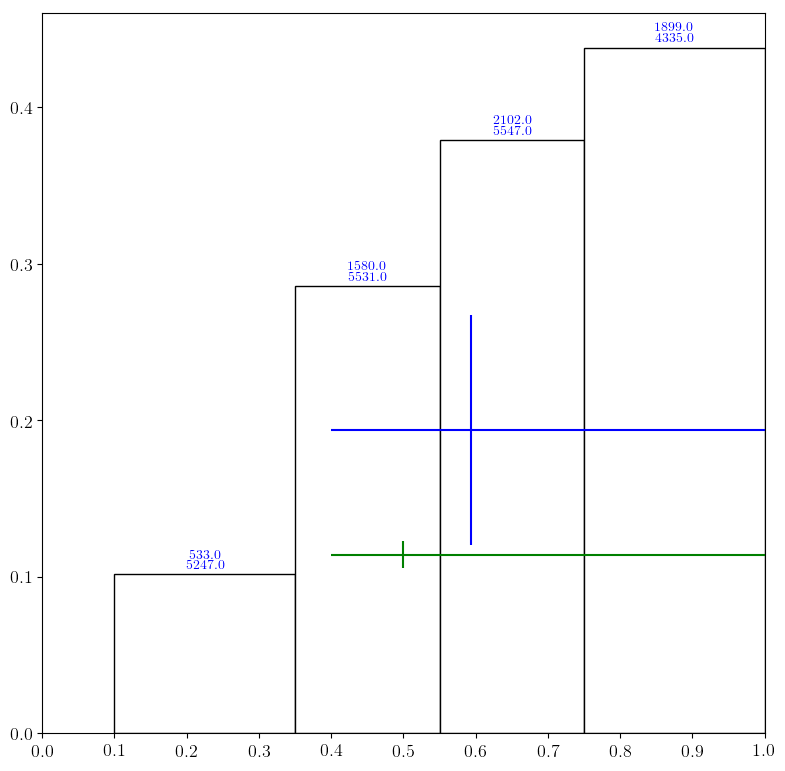

In [22]:
guzmanerror=12.0/21.0*102.0/301.0*np.sqrt(12.0/12.0**2+21.0/21.0**2+102.0/102.0**2+301.0/301.0**2)
guzman=12.0/21.0*102.0/301.0
tolerud=199/1744.
toleruderror=199./1744.*np.sqrt(199./199.**2+1744./1744.**2)

f,ax=plt.subplots(figsize=(8.5,8))
rects=ax.bar(LCBG_FIT_VALS.loc[[ind for ind in LCBG_FIT_VALS.index if 'LCBG' in ind],'ave_z'],
       LCBG_FIT_VALS.loc[[ind for ind in LCBG_FIT_VALS.index if 'LCBG' in ind],'Weighted_Fraction_LCBGS'],
       width=LCBG_FIT_VALS.loc[[ind for ind in LCBG_FIT_VALS.index if 'LCBG' in ind],'low_z']-LCBG_FIT_VALS.loc[[ind for ind in LCBG_FIT_VALS.index if 'LCBG' in ind],'high_z'],
       color='white',
      edgecolor='black')
ax.errorbar(0.594,guzman,yerr=guzmanerror,xerr=[[0.594-0.4],[1-0.594]],label='Guzm$\`{a}$n, 1997',color='blue')
ax.errorbar(0.5,tolerud,yerr=toleruderror,xerr=[[0.1],[0.5]],label='Tollerud, 2010',color='green')
ax.set_xlim([0,1])
ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
autolabel(rects,
          'blue',
          LCBG_FIT_VALS.loc[[ind for ind in LCBG_FIT_VALS.index if 'LCBG' in ind],
                            'WEIGHTED_NGAL'].values.round(),
          GAL_FIT_VALS.loc[[ind for ind in GAL_FIT_VALS.index if '30' not in ind],
                           'WEIGHTED_NGAL'].values.round())
#plt.xlabel('Redshift',fontsize=16)	
#plt.ylabel('N (Mpc$^{-3}$)',fontsize=16)
#plt.legend(loc='2')
plt.subplots_adjust(right=0.98,left=0.13,top=0.97,bottom=0.07)
#plt.savefig('/home/lrhunt/Projects/LCBG_LUMINOSITY_FUNCTION_PLOTTING/PLOTS/PAPER/Number_Density.pdf')